<a href="https://colab.research.google.com/github/A-Kester/csci-451/blob/main/docs/live-notebooks/07-bias-variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More on Overfitting

A theoretical framework for reasoning about model complexity.

## Introduction

Several times in these notes, we’ve seen the topic of *overfitting* arise. In this set of lecture notes, we’ll define overfitting more formally. We’ll then look at overfitting from two perspectives: the bias-variance decomposition, and the modern phenomenon of double descent.

<span class="theorem-title">**Definition 1 (Overfitting)**</span> *Overfitting* refers to any situation in which increasing the complexity of a model causes the model to improve its performance on training data but *worsen* its performance on test data.

In terms of the signal + noise paradigm of modeling,

$$
\begin{align}
y & = f(x) + \epsilon
\end{align}
$$

overfitting occurs when an estimator begins to approximate the noise $\epsilon$ rather than the signal $f(x)$.

For several decades, the received wisdom in the statistics and machine learning communities was that models begin to overfit when they become “too complex.” Model complexity is frequently measured in terms of the number of parameters present in the model. So far in these notes, we’ve exclusively studied models where the number of parameters is equal to the number of features, so another way to think about model complexity is in terms of the total number of features.

## Bias-Variance Decomposition

One theoretical view of the sources of overfitting comes from the *bias-variance* decomposition.

### Many data sets, many models

In the bias-variance decomposition, we consider a *series* of experiments. In each experiment, we pull a data set $(\mathbf{X},\mathbf{y})$ from some data generating distribution, fit a model to that data, and then make a prediction about an element $Y$ in the test set. Since the data set we pull in each experiment is random, the value $Y$ in the test set is random. Furthermore, since the training data is random, the fitted model $\hat{f}$ and the resulting prediction $\hat{Y}$ will also be random.

Let’s illustrate the setup. For the experiments in this chapter, we need to run a LOT of regression models. For this reason, we’ll use a special, very efficient implementation of linear regression that allows us to fit models in closed form. This is not a general approach to fitting models, but it will allow us to run the experiments in this chapter much more quickly.

In [1]:
import torch
class LinearRegression:

  def __init__(self, n_params):
    self.w = torch.zeros(n_params, 1)

  def forward(self, X):
    return X @ self.w

# we don't need gradient descent for Least Squares Linear Regression
class ClosedFormOptimizer: # HW 2 finding best w

  def __init__(self, model):
    self.model = model

  def step(self, X, y):
    self.model.w = torch.linalg.lstsq(X, y).solution

def train(model, X, y):
  opt = ClosedFormOptimizer(model)
  opt.step(X, y)

1.  This is a method that obtains the least-squares solution to the linear regression problem using specialized linear algebra methods. It’s very fast and useful for us today, but doesn’t generalize well to other kinds of machine learning problems.

Now we’ll illustrate generating many data sets from the same data generating distribution, fitting a model, and making a prediction $\hat{Y}$ for some new unseen point $x$ in the test set. For today, we’ll consider the following data generating function, which accepts a fixed set of inputs $x$ and generates a random output $y$ for each input according to the signal + noise paradigm. Unlike in many other models, this particular data generating process gets noisier as $x$ increases, which will allow us to illustrate how the bias and variance of the model can vary across different regions of the input space.

In [2]:
def generate_data(x, sig, freq):
  signal = torch.sin(freq*torch.pi*x) + x
  noise = torch.randn_like(x)*sig*x # noise level varies across the dataset
  y = signal + noise
  return y

Figure 1: Illustration of three different experiments in which we pull a random data set from the data generating process, fit a linear regression model, and make a prediction at a random test point. The data points are shown in black, the fitted model is shown in red, and the prediction at the test point is shown with residual in blue.

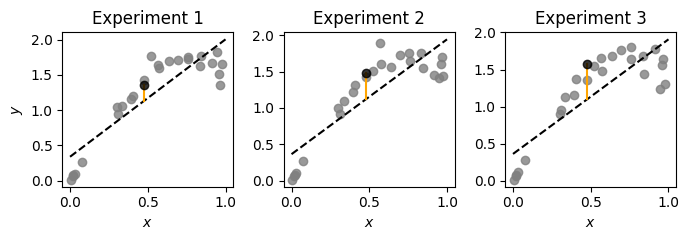

In [3]:
from matplotlib import pyplot as plt

sig = 0.2
freq = 0.8

fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))

n_points = 25
x = torch.rand(n_points,)
x = torch.sort(x).values
test_ix = 10

for i in range(3):
    y = generate_data(x, sig=sig, freq=freq)

    x_test = x[test_ix].unsqueeze(0)
    y_test = generate_data(x_test, sig=sig, freq=freq)
    ax[i].scatter(x, y, alpha=0.8, color='grey')
    ax[i].scatter(x_test, y_test, alpha=0.8, color='k', zorder = 100)
    ax[i].set_title(f"Experiment {i+1}")
    ax[i].set_xlabel(r"$x$")
    if i == 0:
        ax[i].set_ylabel(r"$y$")

    model = LinearRegression(n_params=2)
    X = torch.stack([torch.ones_like(x), x], dim=1)
    train(model, X, y)

    x_viz = torch.linspace(0, 1, 200)
    X_viz = torch.stack([torch.ones_like(x_viz), x_viz], dim=1)
    y_pred = model.forward(X_viz).detach().squeeze()

    ax[i].plot(x_viz, y_pred, color='black', label="Model Prediction", linestyle='--')

    X_test = torch.stack([torch.ones_like(x_test), x_test], dim=1)
    y_pred_test = model.forward(X_test).detach().squeeze()
    ax[i].plot([x_test.item(), x_test.item()], [y_test.item(), y_pred_test.item()], color='orange', label="Prediction at test point", markersize=10, zorder = 10)

plt.tight_layout()

Note that, although each plot is somewhat similar, the data points, fitted model, and prediction at the test point are all *slightly* different across the three experiments. This is because the data we pull in each experiment is random, which causes the fitted model and resulting prediction to also be random.

Let’s repeat the experiment a large number of times and store the results.

In [4]:
n_reps = 1000
targets = torch.zeros(n_reps, len(x))
predictions = torch.zeros(n_reps, len(x))

for i in range(n_reps):
    y_train = generate_data(x, sig=sig, freq=freq)
    X = torch.stack([torch.ones_like(x), x], dim=1)

    model = LinearRegression(n_params=2)
    train(model, X, y_train)
    predictions[i] = model.forward(X)

    targets[i] = generate_data(x, sig=sig, freq=freq)

We now have 1,000 different fitted models and predictions. Let’s visualize the ensemble of fitted models:

Figure 2: Visualization of the ensemble of fitted linear regression models across 1,000 different experiments. The range of predictions at a particular test point is shown in red, while the range of target values at that test point is shown in grey.

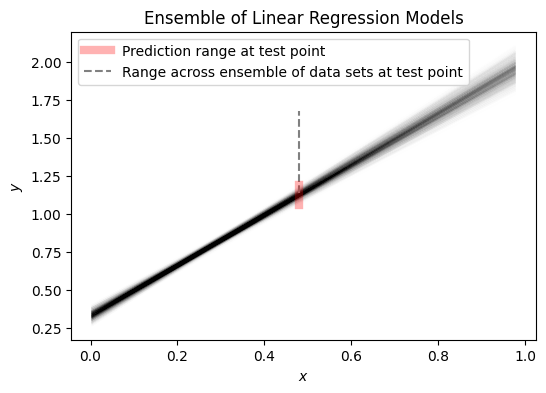

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

test_point_ix = 10
for i in range(n_reps):
    ax.plot([x[0], x[-1]], [predictions[i,0], predictions[i,-1]], color='black', alpha=0.005, zorder = 0)
    ax.set(xlabel = r"$x$", ylabel = r"$y$", title = "Ensemble of Linear Regression Models")

ax.plot([x[test_point_ix], x[test_point_ix]], [predictions[:, test_point_ix].min(), predictions[:, test_point_ix].max()],  color='red', label="Prediction range at test point", zorder = 200, linewidth = 6, alpha = 0.3)
ax.plot([x[test_point_ix], x[test_point_ix]], [targets[:, test_point_ix].min(), targets[:, test_point_ix].max()],  color='grey', label="Range across ensemble of data sets at test point", zorder = 100,  linestyle='--')

l = ax.legend()

Collectively, the models capture the general trend, but each varies slightly from the others. The prediction $\hat{Y}$ at any given point $x$ is random, and the target value $Y$ at that point is also random.

### Decomposing the Error

So, at any given point $x$, we have a random target value $Y$ and a random prediction $\hat{Y}$. We can measure how close $\hat{Y}$ is to $Y$ using the *expected squared error* (this is the theoretical analogue of the MSE): <span class="column-margin margin-aside">Many presentations of the bias-variance decomposition consider the complete expected squared error of the model on *all* possible inputs. This has the effect of throwing an integral sign in front of the calculation, but does not otherwise change the story.</span> $$
\begin{align*}\mathcal{E}& = \mathbb{E}[(Y - \hat{Y})^2]\end{align*}
$$

**Important**: because we are assuming that $Y$ is from the *test* data set, on which $\hat{Y}$ is not trained, $\hat{Y}$ and $Y$ are *independent* random variables.

Let’s now study what contributes to the expected testing squared error $\mathcal{E}$. We can decompose $\mathcal{E}$ into three terms: the *bias* of the model, the *variance* of the model, and the *noise* in the data. It’s helpful to define $\mu = \mathbb{E}[Y]$ and $\hat{\mu} = \mathbb{E}[\hat{Y}]$ to be the expected value of the target and prediction, respectively. $a,b\in \mathbb{R}$

$$
\begin{aligned}
    \mathcal{E}&= \mathbb{E}[(\hat{Y} - Y)^2] \\
    &= \mathbb{E}[\hat{Y}^2 - 2\hat{Y}Y + Y^2] \\
    &= \mathbb{E}[\hat{Y}^2] - 2\mathbb{E}[\hat{Y}]\mathbb{E}[Y] + \mathbb{E}[Y^2] \\
    &= \mathbb{E}[\hat{Y}^2] - 2\hat{\mu}\mu + \mathbb{E}[Y^2] &\quad \text{(independence of $Y$ and $\hat{Y}$)} \\
    &= \mathbb{E}[\hat{Y}^2] - \hat{\mu}^2 + \hat{\mu}^2 - 2\hat{\mu}\mu + \mu^2 + \mathbb{E}[Y^2] - \mu^2 \\
    &= (\mathbb{E}[\hat{Y}^2] - \hat{\mu}^2) + (\hat{\mu} - \mu)^2 + (\mathbb{E}[Y^2] - \mu^2) \\
    &= \underbrace{\mathrm{Var}(\hat{Y})}_\text{model variance} + \underbrace{(\hat{\mu} - \mu)^2}_\text{bias} + \underbrace{\mathrm{Var}(Y)}_\text{noise}
\end{aligned}
$$

Each of the terms in this expression are importantly interpretable:

The **model variance** $\mathrm{Var}(\hat{Y})$ captures how much the prediction $\hat{Y}$ varies across different data sets and fitted models. If the model is very sensitive to the particular data set it is trained on, then the model variance will be high. Models which are more flexible (e.g. by having more parameters and features) tend to have higher model variance.

The **bias** $(\hat{\mu} - \mu)^2$ captures how much the expected prediction $\hat{\mu}$ differs from the expected target $\mu$. If the model is very inflexible and cannot capture the true signal, then the bias will be high. Models which are less flexible (e.g. by having fewer parameters and features) tend to have higher bias.

Finally, the **data noise** $\mathrm{Var}(Y)$ captures how much the target value $Y$ varies across different data sets. This is a property of the data generating process. **It is impossible to achieve test error lower than the data noise**, since the noise is a property of the data generating process and not the model.

Let’s compute each of these terms from the linear regression experiment that we did earlier. Since our analysis above was at a specific data point, we are going to compute values at each data point and then compare.

In [6]:
noise    = targets.var(dim = 0, correction = 0)
variance = predictions.var(dim = 0, correction = 0)
bias     = (targets.mean(dim = 0) - predictions.mean(dim = 0))**2
mse      = ((targets - predictions)**2).mean(dim = 0)

Now we can get a quantitative description of the sources of error in our model by plotting each one and the total mean-squared error. We’ll show this alongside an example data set and predictor for comparison:

Figure 3: Illustration of the bias-variance tradeoff in the repeated linear regression experiment. The left panel shows an example data set and predictor, while the right panel shows the bias, variance, noise, and total mean-squared error as a function of $x$.

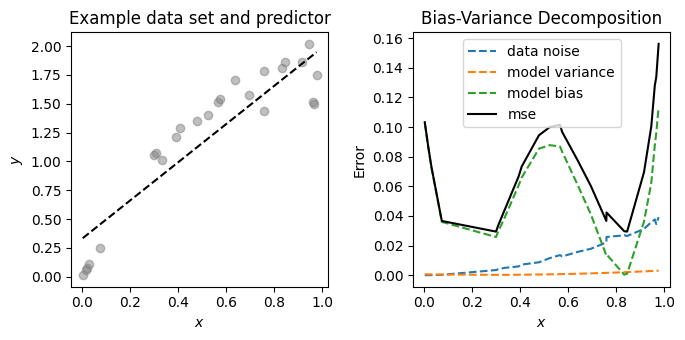

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

ax[0].scatter(x, targets[0], alpha = 0.5, color = "grey")
y_hat = predictions.mean(dim = 0)

ax[0].plot(x, y_hat, color='black', linestyle='--', label="Model Prediction")
ax[0].set(xlabel = r"$x$", ylabel = r"$y$", title = "Example data set and predictor")

ax[1].plot(x, noise, label = "data noise", linestyle = "--")
ax[1].plot(x, variance, label = "model variance", linestyle = "--")
ax[1].plot(x, bias, label = "model bias", linestyle = "--")
ax[1].plot(x, mse, label = "mse", color = "black")

ax[1].set(xlabel = r"$x$", ylabel = "Error", title =
"Bias-Variance Decomposition")

plt.legend()
plt.tight_layout()

In this experiment, the noise and bias are the two primary contributors to the mean-squared error, with the model variance being quite low. The data generating process is deliberately constructed so that the data is noisier in certain regions, and so that the model bias also varies across regions.

### The Bias-Variance Tradeoff

Since the data noise term in the bias-variance decomposition is a property of the data generating process, the only way to reduce test error is to find a model that reduces either the bias or the variance, without increasing the other. We can often tune the bias and variance by adjusting the model complexity. For example, in the linear regression experiment above, we can increase the number of features. This will have the effect of increasing the variance, while reducing the bias. Let’s try this out, generating the same data many times and then evaluating the bias, variance, and noise for different numbers of features.

In [8]:
def polynomial_features(x, degree):
    """Compute polynomial features for input x up to given degree."""
    features = [torch.ones_like(x)]  # x^0
    for d in range(1, degree + 1):
        features.append(x**d)
    return torch.stack(features, dim=1)  # (n_points, degree + 1)

feature_counts = torch.arange(0, 10)

mse_list = []
bias_list = []
variance_list = []
noise_list = []

for degree in feature_counts:
    predictions = torch.zeros(n_reps, len(x))
    targets = torch.zeros(n_reps, len(x))

    for i in range(n_reps):
        y_train = generate_data(x, sig=sig, freq=freq)

        model = LinearRegression(n_params=degree + 1)
        X = polynomial_features(x, degree=degree)
        train(model, X, y_train)
        predictions[i] = model.forward(X).detach().squeeze()

        y_test = generate_data(x, sig=sig, freq=freq)
        targets[i] = y_test

    noise    = targets.var(dim = 0, correction = 0)
    variance = predictions.var(dim = 0, correction = 0)
    bias     = (targets.mean(dim = 0) - predictions.mean(dim = 0))**2
    mse      = ((targets - predictions)**2).mean(dim = 0)


    mse_list.append(mse.mean())
    bias_list.append(bias.mean())
    variance_list.append(variance.mean())
    noise_list.append(noise.mean())

Figure 4: Illustration of the bias-variance tradeoff. As the model becomes more flexible, the bias decreases while the variance increases. The optimal model complexity balances these two sources of error to minimize the mean-squared error.

[]

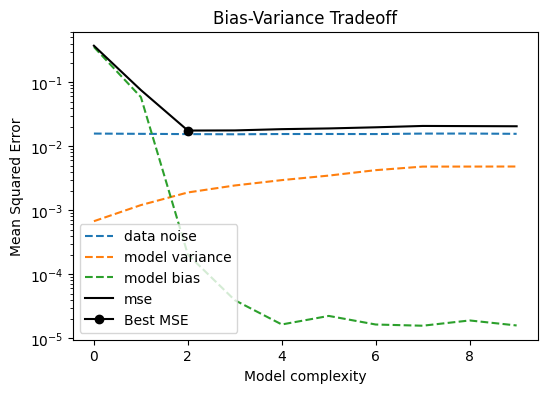

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(feature_counts, noise_list, label = "data noise", linestyle = "--")
ax.plot(feature_counts, variance_list, label = "model variance", linestyle = "--")
ax.plot(feature_counts, bias_list, label = "model bias", linestyle = "--")
ax.plot(feature_counts, mse_list, label = "mse", color = "black")

best_degree = feature_counts[torch.argmin(torch.tensor(mse_list))]
ax.plot(best_degree, mse_list[best_degree], marker='o', color='k', label="Best MSE")

ax.set(xlabel = r"Model complexity", ylabel = "Mean Squared Error", title = "Bias-Variance Tradeoff")
ax.legend()
ax.semilogy()

Figures like <a href="#fig-bias-variance-tradeoff" class="quarto-xref">Figure 4</a> were canon in the machine learning literature for a long time, with a simple message: more model complexity reduces bias but increases variance. Too much complexity will have diminishing rewards for reducing bias but will tend to increase the variance indefinitely, eventually resulting in overfitting. So don’t make your models too complex!

## The Modern Landscape: Interpolation and Double Descent

For a long time in statistics and machine learning, the single-descent curve offered the primary way in which we thought about model complexity. Models with low complexity underfit the data (high bias, low variance), while models with high complexity overfit the data (low bias, high variance). The optimal model complexity balanced these two sources of error to minimize test error. The key was to get *enough* complexity while *avoiding* overfitting. The thing you never wanted to do was to *interpolate* the data, since interpolation is perfect overfitting.

This theoretical story was challenged by the advent of deep learning as a practical tool. Modern deep learning models often have parameter counts in the billions or trillions, which in principle is often enough to perfectly interpolate training data. So why is it that these models nevertheless successfully generalize?

It turns out that there are both *bad* and *good* ways to interpolate your data. Models that have the capacity for “good” interpolation can achieve very low test error even while interpolating the training data. Let’s see an example. <span class="column-margin margin-aside">This example was inspired by [Manuchehr Aminian](https://maminian.github.io/)’s [blog post](https://www.siam.org/publications/siam-news/articles/characterizations-of-double-descent/) in SIAM News on double descent.</span>

For this problem, we’ll suppose that we need to train a model on *very few* data points: <span class="column-margin margin-aside">Some aspects of this experiment, including the very small number of data sets and use of a special set of polynomial basis functions are somewhat contrived (i.e. carefully staged). This is because double descent is primarily a phenomenon that takes place for models with very large parameter counts. Since we want to illustrate this phenomenon in a way that’s easy to visualize, we have to set things up to make sure it happens here.</span>

Figure 5: Example training and test data for the double descent experiment. The true signal is shown in grey, training data as black dots, and test data as black circles.

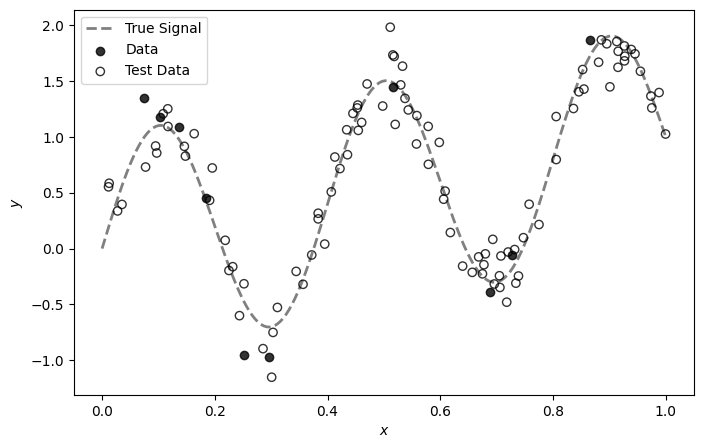

In [10]:
import torch
from matplotlib import pyplot as plt

torch.manual_seed(123)

n_points = 10
sig = 0.2
freq = 5

x = torch.rand(n_points,)
signal = torch.sin(freq * torch.pi * x) + x
noise = torch.randn(n_points,)*sig
y = signal + noise

x_test = torch.rand(10*n_points,)
signal_test = torch.sin(freq * torch.pi * x_test) + x_test
noise_test = torch.randn(10*n_points,)*sig
y_test = signal_test + noise_test

x_viz = torch.linspace(0, 1, 200)
signal_viz = torch.sin(freq * torch.pi * x_viz) + x_viz

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(x_viz, signal_viz, color='grey', label="True Signal", zorder = -10, linewidth=2, linestyle='--')
ax.scatter(x, signal + noise, alpha=0.8, label="Data", color = "k")
ax.scatter(x_test, signal_test + noise_test, alpha=0.8, label="Test Data", color='k', facecolors='none')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()
plt.show()

For our feature map in this experiment, we are going to make use of a special set of polynomial features called [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials). The first few feature maps are:

$$
\begin{align*}
\phi_0(x) & = 1 \\
\phi_1(x) & = x \\
\phi_2(x) & = \frac{1}{2}(3x^2 - 1) \\
\phi_3(x) & = \frac{1}{2}(5x^3 - 3x) \\
\phi_4(x) & = \frac{1}{8}(35x^4 - 30x^2 + 3) \\
\vdots
\end{align*}
$$

It’s ok if these coefficients look quite mysterious and random to you – the study of the Legendre polynomials is a beautiful and deep topic but not our primary purpose here.

In [11]:
def legendre_features(x, degree):
    """Compute Legendre polynomial features for input x up to given degree."""
    features = [torch.ones_like(x)]  # P_0(x) = 1
    if degree >= 1:
        features.append(x)  # P_1(x) = x
    for n in range(2, degree + 1):
        P_n = ((2*n - 1)*x*features[-1] - (n - 1)*features[-2]) / n
        features.append(P_n)
    return torch.stack(features, dim=1)  # (n_points, degree + 1)

We can fit a model using the Legendre polynomial features to data like this:

In [ ]:
# TODO

Let’s now run an experiment in which we vary the number of polynomial features over a broad range and track the training and test mean squared error (MSE). Recall that the number of features is equal to the polynomial degree plus one (to account for the constant feature).

In [12]:
degree_list = list(range(0, 70))
train_mse_list = []
test_mse_list = []
feature_count = []

for degree in degree_list:
    model = LinearRegression(n_params=degree + 1)
    X = legendre_features(x, degree=degree)
    train(model, X, y)

    X_test = legendre_features(x_test, degree=degree)
    y_pred_test = model.forward(X_test).detach().squeeze()
    train_mse = torch.mean((model.forward(X) - y)**2).item()
    test_mse = torch.mean( (y_pred_test - y_test)**2).item()

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    feature_count.append(degree + 1)

Figure 6: Training and test MSE as a function of the number of features. The vertical dashed lines indicate the interpolation threshold and the optimal number of features according to the test MSE. The classical, classical danger zone, and modern regimes are indicated with different background colors.

[]

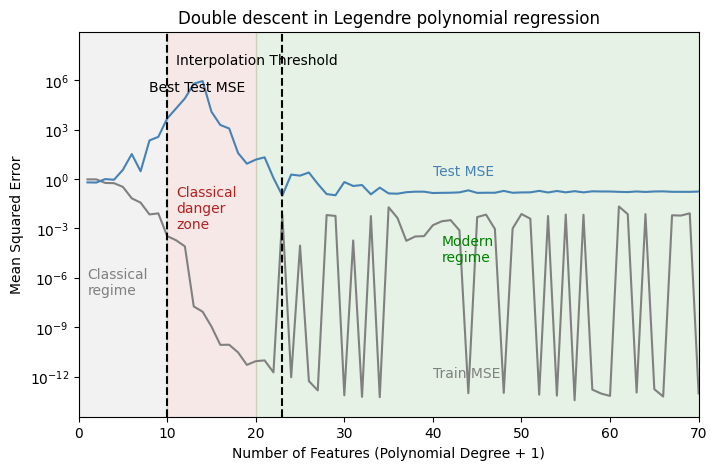

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(feature_count, train_mse_list, color = "grey")
ax.plot(feature_count, test_mse_list, color = "steelblue")
ax.annotate("Train MSE", xy=(feature_count[-1]-30, train_mse_list[-1]*10), color='grey')
ax.annotate("Test MSE", xy=(feature_count[-1]-30, test_mse_list[-1]*10), color='steelblue')

ax.fill_betweenx([1e-20, 1e9], 0, n_points, color='grey', alpha=0.1)
ax.annotate("Classical\nregime", xy=(1, 1e-7), color='grey')

ax.fill_betweenx([1e-20, 1e9], n_points, 2*n_points, color='firebrick', alpha=0.1)
ax.annotate("Classical\ndanger\nzone", xy=(n_points + 1, 1e-3), color='firebrick')

ax.fill_betweenx([1e-20, 1e9], 2*n_points, max(feature_count), color='green', alpha=0.1)
ax.annotate("Modern\nregime", xy=(4*n_points + 1, 1e-5), color='green')


ax.axvline(x=feature_count[torch.argmin(torch.tensor(test_mse_list))], color='black', linestyle='--')
ax.annotate("Best Test MSE", xy=(feature_count[torch.argmin(torch.tensor(test_mse_list))] -15, max(test_mse_list)/4), color='black')

ax.axvline(x=n_points, color='black', linestyle='--')
ax.annotate("Interpolation Threshold", xy=(n_points + 1, max(test_mse_list)*10), color='black')

ax.set_xlabel("Number of Features (Polynomial Degree + 1)")
ax.set_ylabel("Mean Squared Error")
ax.set_title(f"Double descent in Legendre polynomial regression")
ax.set_ylim(min(min(test_mse_list), min(train_mse_list))/10, max(max(test_mse_list), max(train_mse_list))*1000)
ax.set_xlim(0, max(feature_count))
ax.semilogy()

We observe that the test MSE increases considerably as we add more features up to the interpolation threshold, and peaks shortly after. However, as we continue to add features, something surprising happens: the test MSE begins to *decrease* again, and eventually reaches a minimum value *beyond* the interpolation threshold. This is what is sometimes called the “modern regime” for model complexity in high-dimensional machine learning.

What does this look like in terms of the actual models we fit?

Figure 7: Legendre polynomial regression models (red) with different numbers of features, visualized with training and test data as well as the true signal (black).

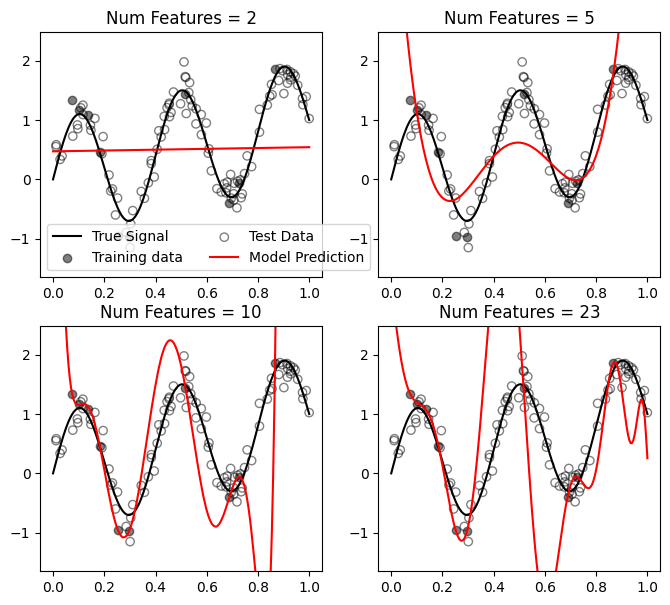

In [14]:
fig, axarr = plt.subplots(2, 2, figsize=(8, 7))
best_num_features = feature_count[torch.argmin(torch.tensor(test_mse_list))]

for i, num_features in enumerate([2, 5, 10, best_num_features]):

    degree = num_features - 1
    model = LinearRegression(n_params=degree + 1)
    X = legendre_features(x, degree=degree)
    train(model, X, y)

    x_viz = torch.linspace(0, 1, 200)
    X_viz = legendre_features(x_viz, degree=degree)
    y_pred = model.forward(X_viz).detach().squeeze()

    ax = axarr.flatten()[i]

    ax.plot(x_viz, signal_viz, color='k', label="True Signal", zorder = -10)
    ax.scatter(x, signal + noise, alpha=0.5, label="Training data", color = "k")
    ax.scatter(x_test, signal_test + noise_test, alpha=0.5, label="Test Data", color='k', facecolors='none')

    ax.plot(x_viz, y_pred, color='red', label="Model Prediction")
    ax.set_title(f"Num Features = {num_features}")
    ax.set_ylim(min(y_test.min(), y.min()) - 0.5, max(y_test.max(), y.max()) + 0.5)

    if i == 0:
        ax.legend(ncol = 2)

We observe that for small number of features, the model *underfits* the data, while as we approach the interpolation threshold the model *overfits* the data in a way that causes the model predictions to swing wildly. However, as we increase the number of features further, the model predictions become much smoother and closer to the true signal, which explains the improved test MSE.

Double descent remains an actively explored area of research with major practical implications in the context of deep learning models.